In [1]:
!pip install wfdb
!pip install neurokit2
!pip install pandas numpy matplotlib



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import wfdb
import os

# Path to your dataset folder
data_folder = "Dataset/ptbxl_data"

# Load the metadata
df = pd.read_csv(os.path.join(data_folder, "ptbxl_database.csv"))

# Choose a sample record (100Hz version is easier to process)
sample_path = df.loc[0, 'filename_lr']  # low resolution path
record_path = os.path.join(data_folder, sample_path)

# Load the ECG signal and metadata using wfdb
signal, info = wfdb.rdsamp(record_path)

print("Signal shape:", signal.shape)  # (1000, 12) → 10 seconds, 12 leads


Signal shape: (1000, 12)


In [4]:
import neurokit2 as nk

# Choose Lead II for simplicity
ecg_lead = signal[:, 1]

# Clean the ECG signal (NeuroKit2 uses a bandpass filter internally)
ecg_cleaned = nk.ecg_clean(ecg_lead, sampling_rate=100)


In [5]:
# Detect R-peaks
peaks, info = nk.ecg_peaks(ecg_cleaned, sampling_rate=100)

# R-peaks indices
r_peaks = info["ECG_R_Peaks"]

print("R-peak indices:", r_peaks)
print("Number of R-peaks detected:", len(r_peaks))


R-peak indices: [115 208 300 393 487 583 679 773 864 961]
Number of R-peaks detected: 10


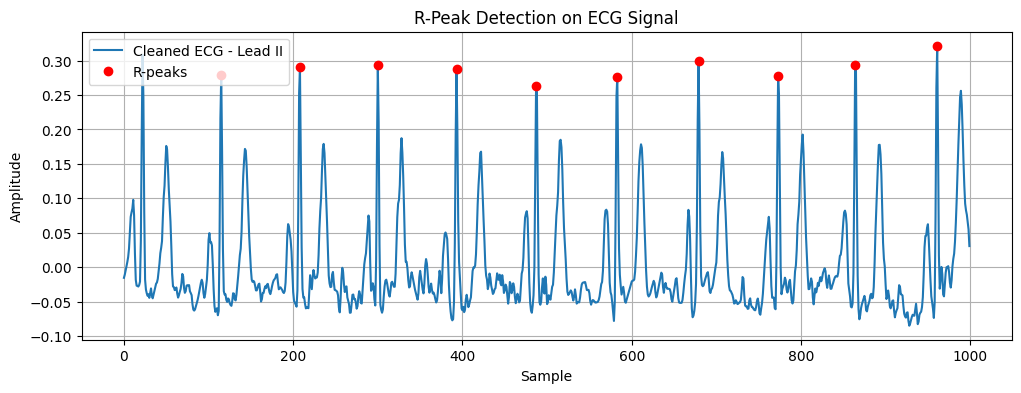

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(ecg_cleaned, label='Cleaned ECG - Lead II')
plt.plot(r_peaks, ecg_cleaned[r_peaks], 'ro', label='R-peaks')
plt.title("R-Peak Detection on ECG Signal")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()


In [7]:
all_r_peaks = []

for i in range(5):  # example: first 5 records
    sample_path = df.loc[i, 'filename_lr']
    record_path = os.path.join(data_folder, sample_path)
    signal, _ = wfdb.rdsamp(record_path)
    ecg_cleaned = nk.ecg_clean(signal[:, 1], sampling_rate=100)  # Lead II
    _, peak_info = nk.ecg_peaks(ecg_cleaned, sampling_rate=100)
    r_peaks = peak_info["ECG_R_Peaks"]
    
    all_r_peaks.append({
        "ecg_id": df.loc[i, 'ecg_id'],
        "patient_id": df.loc[i, 'patient_id'],
        "num_r_peaks": len(r_peaks),
        "r_peak_indices": r_peaks
    })

# Convert to DataFrame
r_peaks_df = pd.DataFrame(all_r_peaks)
print(r_peaks_df.head())


   ecg_id  patient_id  num_r_peaks  \
0       1     15709.0           10   
1       2     13243.0            7   
2       3     20372.0           10   
3       4     17014.0           12   
4       5     17448.0           11   

                                      r_peak_indices  
0  [115, 208, 300, 393, 487, 583, 679, 773, 864, ...  
1                [100, 231, 368, 502, 627, 747, 863]  
2  [104, 202, 298, 394, 485, 577, 670, 764, 857, ...  
3  [108, 191, 279, 364, 446, 522, 601, 680, 762, ...  
4  [33, 123, 219, 313, 399, 482, 571, 669, 764, 8...  


In [8]:
sample_path = df.loc[0, 'filename_lr']
record_path = os.path.join(data_folder, sample_path)
signal, _ = wfdb.rdsamp(record_path)

# Use Lead II (index 1)
ecg_lead = signal[:, 1]

In [9]:
# Clean ECG (bandpass filter applied)
ecg_cleaned = nk.ecg_clean(ecg_lead, sampling_rate=100)


In [10]:
signals, wave_peaks = nk.ecg_delineate(ecg_cleaned, r_peaks, sampling_rate=100, method="peak")

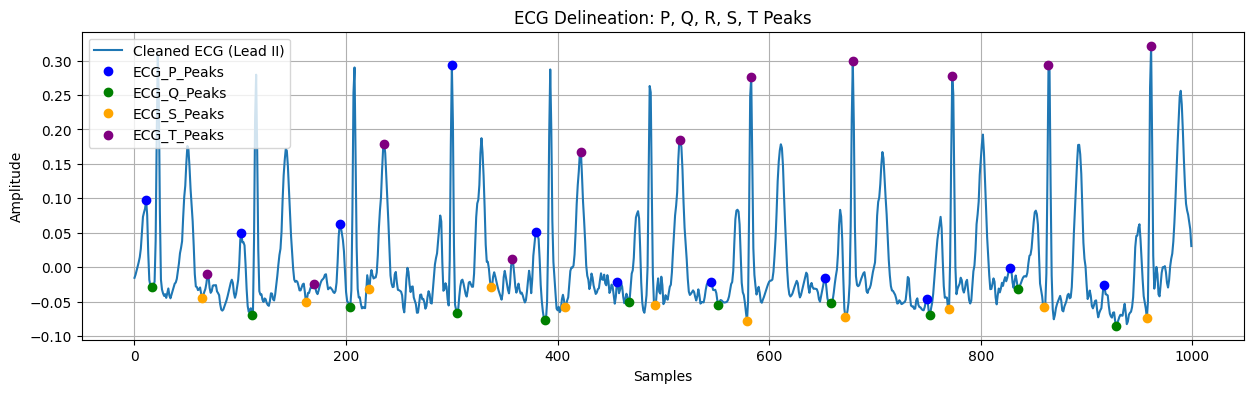

In [11]:
plt.figure(figsize=(15, 4))
plt.plot(ecg_cleaned, label="Cleaned ECG (Lead II)")

# Plot peaks if they exist
for label, color in zip(["ECG_P_Peaks", "ECG_Q_Peaks", "ECG_R_Peaks", "ECG_S_Peaks", "ECG_T_Peaks"],
                        ['blue', 'green', 'red', 'orange', 'purple']):
    indices = wave_peaks.get(label)
    if indices is not None:
        plt.plot(indices, ecg_cleaned[indices], 'o', label=label, color=color)

plt.legend()
plt.title("ECG Delineation: P, Q, R, S, T Peaks")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()
